In [1]:
import torch
import torch.nn as nn

from timm.optim import Adan
from timm.scheduler import CosineLRScheduler

import albumentations as A
from albumentations.pytorch import ToTensorV2

import tqdm
import numpy as np
from accelerate import Accelerator

from utils import (
    util,
    vision,
    modules,
    coco_metrics,
    combo_augment,
    custom_dataset, 
)

/home/zhy/miniconda3/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [2]:
# accelerator = Accelerator()
# device = accelerator.device

# torch.set_float32_matmul_precision('high')

# Parameters

In [3]:
BATCH_SIZE = 1
NUM_WORKDERS = 1
IMG_PREFIX = "data/train/"
TRAIN_ANN_FILE = "data/train_coco.json"
VALID_ANN_FILE = "data/valid_coco.json"

MODEL_CFG_CONFIG = "config.py"

IMAGE_SHAPE = (384, 384)
train_transform = A.Compose(
    [
        A.OneOf(
                [
                    A.SmallestMaxSize(max_size=400, p=.25),
                    A.SmallestMaxSize(max_size=480, p=.25),
                    A.SmallestMaxSize(max_size=576, p=.25),
                    A.SmallestMaxSize(max_size=768, p=.25),
                ],
                p=.6
            ),
            A.RandomSizedBBoxSafeCrop(*IMAGE_SHAPE, p=1.),
            A.Flip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=180, scale_limit=.2, value=255, p=.6),
            A.PixelDropout(drop_value=255),
            A.Cutout(num_holes=48, max_h_size=16, max_w_size=16, fill_value=255, p=0.5),
            
            A.OneOf([
                A.GaussNoise(),
            ], p=0.2),
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            A.OneOf([
                A.CLAHE(),
                A.IAASharpen(),
                A.IAAEmboss(),
                A.RandomBrightnessContrast(),
            ], p=0.25),
    ],
    bbox_params=A.BboxParams(
        format='coco',
    )
)
valid_transform = A.Compose(
    [
        A.RandomSizedBBoxSafeCrop(640, 640),
        A.Normalize(),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='coco',
    )
)

copy_past_param = dict(
    classes=[1, 2, 4, 7],
    add_box_num=3,
    p=.8
)

mosaic_param = dict(
    image_shape=IMAGE_SHAPE
)


EPOCHS = 100
LR = 3e-4
WARMUP_LR_INIT = 1e-5
WEIGHT_DECAY = 3e-4
VALID_EPOCH = 5

MODEL_NAME = "RTMDet"
cur_epoch = 1

/home/zhy/miniconda3/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/zhy/miniconda3/lib/python3.10/site-packages/albumentations/imgaug/transforms.py:174: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


# DataLoader

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    custom_dataset.CustomDatset(
        TRAIN_ANN_FILE,
        IMG_PREFIX,
        train_transform,
        mosaic_param=mosaic_param,
        # copy_past_param=copy_past_param,
        double_mixup_param=mosaic_param,
        use_mixup=True,
        use_mask_bg=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKDERS,
    collate_fn=custom_dataset.collate_fn,
    pin_memory=False
)

valid_dataloader = torch.utils.data.DataLoader(
    custom_dataset.CustomDatset(
        VALID_ANN_FILE,
        IMG_PREFIX,
        valid_transform,
    ),
    batch_size=1,
    shuffle=True,
    num_workers=NUM_WORKDERS,
    collate_fn=custom_dataset.collate_fn,
)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
--- Pseudo Data Have 0 ---
Use Copy: False
Use Mosaic: True
Use Double Mixup: True
Use Mixup: True
Use Mask BG: True

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


tensor([3, 3, 7, 3, 4, 1, 3, 1])


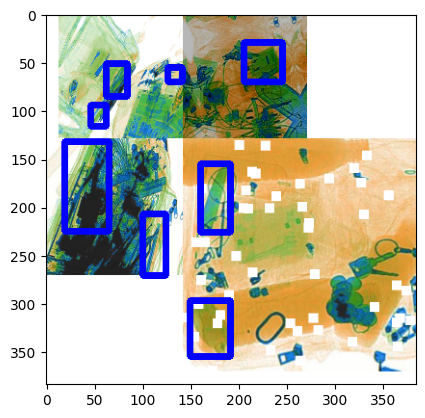

In [45]:
batch = next(iter(train_dataloader))
batch["inputs"] = batch["inputs"].to(torch.uint8)
vision.vision_batch0(batch)

In [6]:
raise 1 == 2

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 raise 1 == 2                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: exceptions must derive from BaseException

# Model

In [ ]:
model = modules.Model(MODEL_CFG_CONFIG)

# Runtime

In [ ]:
optimizer = Adan(
    util.get_param_groups(model),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)
lr_scheduler = CosineLRScheduler(
    optimizer,
    EPOCHS,
    warmup_t=EPOCHS // 8,
    warmup_lr_init=WARMUP_LR_INIT,
)

In [ ]:
model, optimizer, train_dataloader, valid_dataloader, lr_scheduler = accelerator.prepare(
    model, 
    optimizer,
    train_dataloader,
    valid_dataloader,
    lr_scheduler
)

In [ ]:
def train_one_epoch(model, dataloader, optimizer):
    dataloader = tqdm.tqdm(dataloader, disable=not accelerator.is_main_process)

    model.train()
    losses = 0
    cls_losses = 0
    bbox_losses = 0
    for batch in dataloader:
        optimizer.zero_grad()
        cls_loss, bbox_loss = model(batch, mode="loss")
        cls_losses += cls_loss.item()
        bbox_losses += bbox_loss.item()
        losses += (cls_loss.item() + bbox_loss.item())
        accelerator.backward(cls_loss + bbox_loss)
        optimizer.step()
    
    return (
        losses / len(dataloader),
        cls_losses / len(dataloader),
        bbox_losses / len(dataloader),
    )

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader):
    dataloader = tqdm.tqdm(dataloader, disable=not accelerator.is_main_process)
    
    model.eval()
    predict = []
    for batch in dataloader:
        out = model(batch, mode="predict")
        for data_sample in out:
            image_id = data_sample.image_id
            pred_instances = data_sample.pred_instances
            for i in range(len(pred_instances.labels)):
                predict.append(
                    np.array([
                        image_id,
                        *pred_instances.bboxes[i].detach().cpu(),
                        pred_instances.scores[i].detach().cpu(),
                        pred_instances.labels[i].detach().cpu()
                    ])
                )
    predict = np.stack(predict)
    coco_metrics.evaluator(VALID_ANN_FILE, predict)

In [ ]:
min_loss = float("inf")
max_score = 0
for epoch in range(cur_epoch, EPOCHS + 1):
    # # # # #
    # Train #
    # # # # #
    loss, cls_loss, bbox_loss = train_one_epoch(model, train_dataloader, optimizer)
    accelerator.wait_for_everyone()
    lr_scheduler.step(epoch)
    accelerator.print(
        f"Epoch {epoch} - Loss: {loss :.4f}"
        f"\tlr: {optimizer.param_groups[0]['lr']*1e4 :.4f}\t"
        f"cls_loss: {cls_loss :.3f}\t"
        f"bbox_loss: {bbox_loss :.3f}"
    )
    if min_loss > loss:
        min_loss = loss
    # if epoch == int(EPOCHS // 6):
    #     util.update_dropout_rate(model, .0)
    if accelerator.is_local_main_process:
        torch.save(
            {
                "model": accelerator.unwrap_model(model).state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            },
            f"work_dir/{MODEL_NAME}_all.pt"
        )

        torch.save(
            {
                "model": accelerator.unwrap_model(model).state_dict(),
                # "ema": ema_model.module.state_dict()
            },
            f"work_dir/{MODEL_NAME}_model.pt"
        )
        
    # # # # #
    # Valid #
    # # # # #
    if epoch % VALID_EPOCH == 0:
        valid_one_epoch(model, valid_dataloader)